# data visualization
In this notebook, SQL queries will be implemented to extract data based on specific filtering criteria. This data will then be read into Pandas dataframes, after which several visuals will be generated (based on the data) using Matplotlib. It's important to note that although these filters could be done by reading the full database into Pandas dataframes and then filtering, keeping the entire data filtering process within Python and Pandas/NumPy, PyMySQL will be used to extract specific data on a per-visual basis instead.

In [54]:
#datbase connector
import pymysql as pms
#local dataframe representations of data
import pandas as pd
#used for quick testing of concepts, but also for math
import numpy as np

## grabbing data
The below function will be utilized again and again to connect to the database, execute a SQL query, extract a result into a Pandas dataframe, and close the database connection. But, first we need to read in the database credentials required for connecting to the MySQL client.

In [55]:
db_user = ""
db_pass = ""
db_name = ""
db_host = ""
db_charset = "utf8"
with open("database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()

In [56]:
def grab_data(sql):
    """
    1. Open a connection to MySQL using PyMySQL
    2. Grab data based on the specified SQL query and store it in a Pandas dataframe
    3. Close the PyMySQL connection
    4. Return the Pandas dataframe
    """
    try:
        #connect
        con = pms.connect(host=db_host, user=db_user, passwd=db_pass, db=db_name, charset=db_charset)
        #print("Connected: {}".format(con.open))
        
        #execute query and read into dataframe
        #(https://stackoverflow.com/questions/12047193/how-to-convert-sql-query-result-to-pandas-data-structure?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
        df = pd.read_sql(sql, con)
    except:
        print("You messed up")
    finally:
        if con:
            #close connection
            con.close()
            #print("Connected: {}".format(con.open))
    
    #return dataframe
    return df

## sample plot
This notebook will utilize [Seaborn](https://seaborn.pydata.org/index.html), a library built on top of [Matplotlib](https://matplotlib.org/), for data visualization. Below we use Seaborn to show the distribution of the Women's division's back squat, clean and jerk, deadlift, and snatch for those who competed in the 2018 CrossFit Open.

In [57]:
#extract data
womens_lifts_df = grab_data(
    """
    SELECT back_squat_lbs, clean_and_jerk_lbs, snatch_lbs, deadlift_lbs FROM athlete WHERE division_id=2 AND (
        back_squat_lbs > 0 AND
        clean_and_jerk_lbs > 0 AND
        snatch_lbs > 0 AND
        deadlift_lbs > 0
    );
    """
)

In [58]:
#import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sb

In [59]:
#show sample of data
womens_lifts_df.head(10)

,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs
0,315,220,169,352
1,275,220,180,385
2,350,230,185,365
3,341,260,220,363
4,285,210,170,340
5,275,227,185,335
6,245,212,170,300
7,275,220,175,345
8,265,220,175,395
9,310,230,190,300


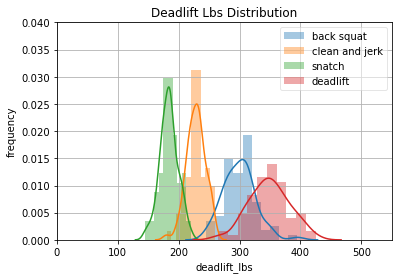

In [65]:
#plot each lift
for c in womens_lifts_df.columns:
    #fit plot
    sb.distplot(np.array(womens_lifts_df[c]), bins=10, label=c[:-4].replace("_", " "))
    #label axes and add to labels for legend
    plt.xlabel(c)
    plt.ylabel("frequency")
    #grid
    plt.grid(True)
    #title
    plt.title(c.replace("_", " ").title() + " Distribution")
#axes bounds
plt.axis([0, 550, 0, 0.04])
#legend (.get_frame().set_alpha() sets the backgroudn on the legend)
#plt.legend()
plt.legend().get_frame().set_alpha(0.5)
#show
plt.show()

## scoring athletes basedon performance
Athlete scoring has been written in a separate module called `scorer`. The scorer.py file can be found in this repo, and contains in-depth documentation of how athletes are evaluated. The scoring metric implemented in very similar (but not identical) to that of the CrossFit leaderboard.

One important thing to note is that the leaderboard function was written to reduce repetitive code as much as possible. Therefore, in order to avoid opening connections this notebook within `try` blocks and having to close them and monitor exceptions, the leaderboard expects to open the database connection on it's own.
Given this, the leaderboard function expects a list containing the required database credentials, where the order is the same as that of the `pms.connect()` parameter list in `grab_data()` (host, user, passwd, db, charset).

In [61]:
import importlib
import scorer

In [62]:
"""["id", "name"] + ["leaderboard_{}".format(c) for c in [
        "18_1_reps",
        "18_2_time_secs",
        "18_2a_weight_lbs",
        "18_3_reps",
        "18_4_time_secs",
        "18_5_reps"
    ]]"""

'["id", "name"] + ["leaderboard_{}".format(c) for c in [\n        "18_1_reps",\n        "18_2_time_secs",\n        "18_2a_weight_lbs",\n        "18_3_reps",\n        "18_4_time_secs",\n        "18_5_reps"\n    ]]'

In [63]:
#database credentials
creds = [db_host, db_user, db_pass, db_name, db_charset]
#may need to reimport scorer module if changing code inside it between runs
importlib.reload(scorer)
mens_open_lb = scorer.leaderboard(
    18,
    0,
    10,
    #["id", "name", "back_squat_lbs", "sprint_400_m_time_secs", "max_pull_ups", "deadlift_lbs"],
    ["id", "name"] + ["leaderboard_{}".format(c) for c in [
        "18_4_time_secs",
        #"18_5_reps"
    ]],
    creds
)

In [64]:
mens_open_lb.head(10)

,id,name,leaderboard_18_4_time_secs,rank
149,255163,MICHAEL LAVERRIERE,449,0
103,124483,JOSH BRIDGES,465,1
119,164390,ALEXANDRE JOLIVET,470,2
47,21403,DANNY NICHOLS,485,3
194,879283,KONSTANTINOS PAPADOPOULOS,499,4
108,135283,GAVIN WARD,504,5
117,157939,LUKASZ TRZONKOWSKI,523,6
160,297862,KYLE KLEINSCHMIDT,527,7
111,138674,JOEL BRAN,527,8
142,239634,DAVID CRESPO TAMMELIN,530,9
